In [1]:
import numpy as np
from core.lattice import lattice_2D
from core.LLGS_simulation import LLGS_Simulation_2D
from core.read_results import ReadResult
from param.NiPS3 import NiPS3_params

`lattice_2D(n_a, n_b, n_site)` creates a lattice consisting of `n_a * n_b` unit cells, each containing `n_site` sites. The total number of sites, $ N $, is calculated as $ N = n_a \cdot n_b \cdot n_{site} $.

Using `.set_position(r_a, r_b, r_site)`, the geometry of the lattice is defined, where $ r_a $ and $ r_b $ are the basis vectors of the unit cell, and $ r_{\text{site}}[i] $ specifies the position of the $ i $-th site.

<Figure size 640x480 with 0 Axes>

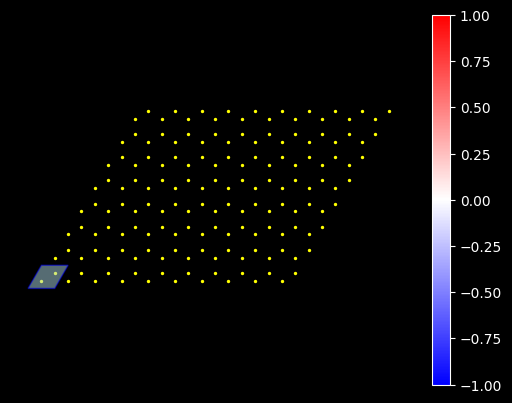

In [2]:
honeycomb = lattice_2D(n_a = 10, n_b = 8, n_site = 2)

honeycomb.set_position(
    r_a = np.array([np.sqrt(3), 0]),
    r_b = np.array([0.5*np.sqrt(3), 1.5]),
    r_site = np.array((
    [0.5*np.sqrt(3), 0.5], #first site
    [np.sqrt(3), 1] #second site
    ))
)
honeycomb.plot(draw_unitcell=True)

The `.structure` attribute is a DataFrame with $N$ rows, where the columns are:  
- `a`, `b`, `site` (lattice indices)  
- `x`, `y` (spatial coordinates)

This structure is particularly useful for initializing spins and computing the exchange field matrix.

In [3]:
honeycomb.structure

,a,b,site,x,y
particle idx,,,,,
0,0,0,0,0.866025,0.5
1,0,0,1,1.732051,1.0
2,0,1,0,1.732051,2.0
3,0,1,1,2.598076,2.5
4,0,2,0,2.598076,3.5
...,...,...,...,...,...
155,9,5,1,21.650635,8.5
156,9,6,0,21.650635,9.5
157,9,6,1,22.516660,10.0


`.initialize_spin()` accepts a dictionary where string-based conditions (evaluated on the structure) are mapped to spin vectors.

<Figure size 640x480 with 0 Axes>

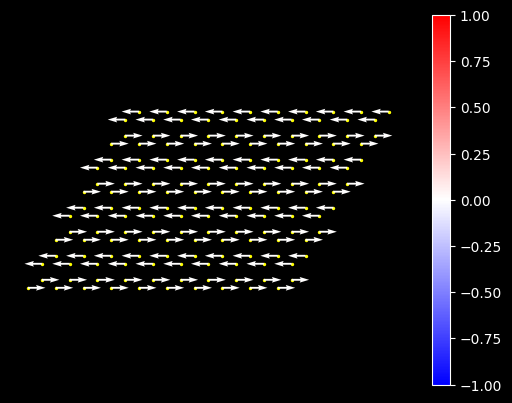

In [4]:
ZigZag_config = {"b % 2 == 0": np.array([1,0,0]),
                "b % 2 == 1": np.array([-1,0,0])}
honeycomb.initialize_spin(ZigZag_config)
honeycomb.plot()

By mapping pairwise distances to nearest-neighbor, next-nearest-neighbor, and next-next-nearest-neighbor interactions, the exchange field matrix $H_E$ is computed. Its entries, $H_{Eij}$, contribute to the exchange energy:

$H_{\text{ex}} = \sum_{i,j} H_{Eij} S_i S_j$

In [5]:
def H_E_honeycomb(honeycomb: lattice_2D, J_1 = 0, J_2 = 0, J_3 = 0):
    positions = honeycomb.structure[['x','y']].values # (N,2)
    pairwise_distances = np.linalg.norm(positions[:, None, :] - positions[None, :, :], axis = -1) # (N,N)

    H_E = np.zeros(pairwise_distances.shape)
    H_E[np.isclose(pairwise_distances, 1, atol = 1e-3, rtol=0)] = J_1/2
    H_E[np.isclose(pairwise_distances, np.sqrt(3) , atol = 1e-3, rtol=0)] = J_2/2
    H_E[np.isclose(pairwise_distances, 2 , atol = 1e-3, rtol=0)] = J_3/2
    return H_E

H_E = H_E_honeycomb(honeycomb, 
                    J_1 = NiPS3_params['J1'],
                    J_2 = NiPS3_params['J2'],
                    J_3 = NiPS3_params['J3'],
                    )
print(H_E.round(1))

[[  0.  -11.2   0.9 ...   0.    0.    0. ]
 [-11.2   0.  -11.2 ...   0.    0.    0. ]
 [  0.9 -11.2   0.  ...   0.    0.    0. ]
 ...
 [  0.    0.    0.  ...   0.  -11.2   0.9]
 [  0.    0.    0.  ... -11.2   0.  -11.2]
 [  0.    0.    0.  ...   0.9 -11.2   0. ]]


### LLGS Simulation in 2D  
`LLGS_Simulation_2D` performs the simulation through the following steps:  

1. **Set up fields:**  
    - Exchange field: `.set_exchange_field()`  
    - DMI field: `.set_DMI_field_x()`, `.set_DMI_field_y()`, `.set_DMI_field_z()`  
    - External fields: `.set_H_ext()`, `.set_H_FL()`, `.set_H_DL()`  

2. **Set parameters with `.setup()`:**  
    - **Material parameters:**  
        - `H_para`: In-plane easy-axis anisotropy  
        - `H_perp`: Out-of-plane perpendicular anisotropy  
        - `phi_a`: Angle between the a-axis and x-axis  
        - `alpha`: Gilbert damping coefficient  
    - **Experimental parameters:**  
        - `io_foldername`: Folder to save data  
        - `io_filename`: Name of the data file  
        - `io_compress`: Compress the data  
        - `io_screen`: Display progress  

3. **Run the simulation with `.evolve()`:**  
    - The simulation evolves based on the Landau-Lifshitz-Gilbert-Slonczewski (LLGS) equation:  
    $
    \frac{d \mathbf{S}_i}{\gamma dt} = \mathbf{H}_{\text{eff},i} \times \mathbf{S}_i + (\mathbf{H}_D \times \mathbf{S}_i) \times \mathbf{S}_i
    $
    where:  
    $
    \mathbf{H}_{\text{eff},i} = -\frac{1}{\hbar \gamma} \frac{\delta E}{\delta \mathbf{S}_i}, 
    $
    
        and, 
        $
        \frac{E}{\hbar \gamma} = \sum_{i,j} H_{Eij} \mathbf{S}_i \cdot \mathbf{S}_j + H_\perp \sum_i \left( \mathbf{S}_i \cdot \hat{\mathbf{z}} \right)^2 - H_\parallel \sum_i \left( \mathbf{S}_i \cdot \hat{\mathbf{x}} \right)^2 - \sum_{i,j} H_{\text{DMI},ij} \cdot \left( \mathbf{S}_i \times \mathbf{S}_j \right) - \mathbf{H}_t \cdot \left( \sum_i \mathbf{S}_i \right)
        $

    (see https://doi.org/10.1016/j.jmmm.2022.169362 for detail)
    
    The output is a $(T, N, 3)$ ndarray, where $ T $ represents time steps, $ N $ represents spin sites, and the last dimension represents the components $ S_x, S_y, S_z $.  

The results are normalized to $ |S| = 1 $ at each step and are returned through `.evolve()`.

In [6]:
fdn = "Data/NiPS3"
method = "RK4"
dt = 2e-4
max_iters = 50000

H_ext = np.array([5.,5.,0.])

sim = LLGS_Simulation_2D(honeycomb)
sim.set_exchange_field(H_E = H_E)
sim.set_H_ext(H_ext = H_ext)
sim.setup(alpha = 0.1, 
          H_para = NiPS3_params['H_para'], 
          H_perp = NiPS3_params['H_perp'],
          io_foldername = fdn,
          method = method)
sim.evolve(honeycomb, dt=dt, max_iters=max_iters)

simulation: 100%|██████████| 50000/50000 [00:07<00:00, 6437.84it/s] 


saving data to Data/NiPS3/results_RK4.h5 ...
simulation is done


### Simulation Results  
The results include the following attributes:  
- **`times`**: An \( (T,) \) ndarray representing the time steps used in the simulation.  
- **`spin_datas`**: An \( (T, N, 3) \) ndarray containing spin data recorded during the simulation.

Methods:  
- **`animate()`**: Generates animations (e.g., MP4, GIF) of the spin evolution.

<Figure size 640x480 with 0 Axes>

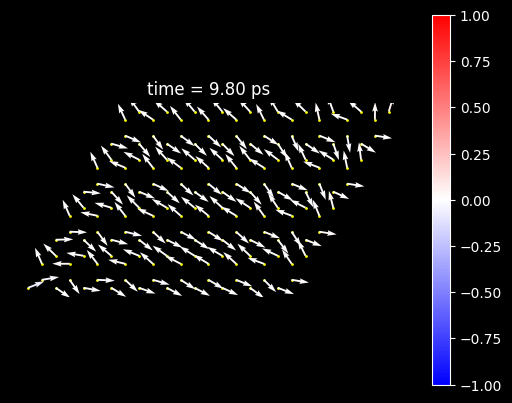

In [7]:
results = ReadResult(f'{fdn}/results_RK4.h5')
results.animate(period = 1000, save_fn = f'doc/spin_animation.gif')